Modelo clasificactorio para predecir el tipo de tumor que el pasiente tiene
Autor:Hector vejar casillas

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression

Exploracion de los datos para asegurar la calidad de los mismos

In [164]:
#https://www.kaggle.com/datasets/miadul/brain-tumor-dataset
brainDataset = pd.read_csv('./brain_tumor_dataset.csv')
brainDataset.head()

,Patient_ID,Age,Gender,Tumor_Type,Tumor_Size,Location,Histology,Stage,Symptom_1,Symptom_2,Symptom_3,Radiation_Treatment,Surgery_Performed,Chemotherapy,Survival_Rate,Tumor_Growth_Rate,Family_History,MRI_Result,Follow_Up_Required
0,1,73,Male,Malignant,5.375612,Temporal,Astrocytoma,III,Vision Issues,Seizures,Seizures,No,No,No,51.312579,0.111876,No,Positive,Yes
1,2,26,Male,Benign,4.847098,Parietal,Glioblastoma,II,Headache,Headache,Nausea,Yes,Yes,Yes,46.373273,2.165736,Yes,Positive,Yes
2,3,31,Male,Benign,5.588391,Parietal,Meningioma,I,Vision Issues,Headache,Seizures,No,No,No,47.072221,1.884228,No,Negative,No
3,4,29,Male,Malignant,1.436600,Temporal,Medulloblastoma,IV,Vision Issues,Seizures,Headache,Yes,No,Yes,51.853634,1.283342,Yes,Negative,No
4,5,54,Female,Benign,2.417506,Parietal,Glioblastoma,I,Headache,Headache,Seizures,No,No,Yes,54.708987,2.069477,No,Positive,Yes


In [166]:
brainDataset = brainDataset.drop('Patient_ID',axis=1)
print(brainDataset.describe())
print(brainDataset.isnull().sum())

                Age    Tumor_Size  Survival_Rate  Tumor_Growth_Rate
count  20000.000000  20000.000000   20000.000000       20000.000000
mean      49.433700      5.236552      70.131699           1.547701
std       17.389296      2.754359      17.270834           0.835995
min       20.000000      0.500410      40.002386           0.100017
25%       34.000000      2.836686      55.224439           0.830433
50%       49.000000      5.200675      70.305066           1.541821
75%       65.000000      7.624299      85.043395           2.262484
max       79.000000      9.999420      99.998125           2.999835
Age                    0
Gender                 0
Tumor_Type             0
Tumor_Size             0
Location               0
Histology              0
Stage                  0
Symptom_1              0
Symptom_2              0
Symptom_3              0
Radiation_Treatment    0
Surgery_Performed      0
Chemotherapy           0
Survival_Rate          0
Tumor_Growth_Rate      0
Family_Histor

Evaluamos la correlacion entre variables y observamos como existe una alta correlacion entre variables

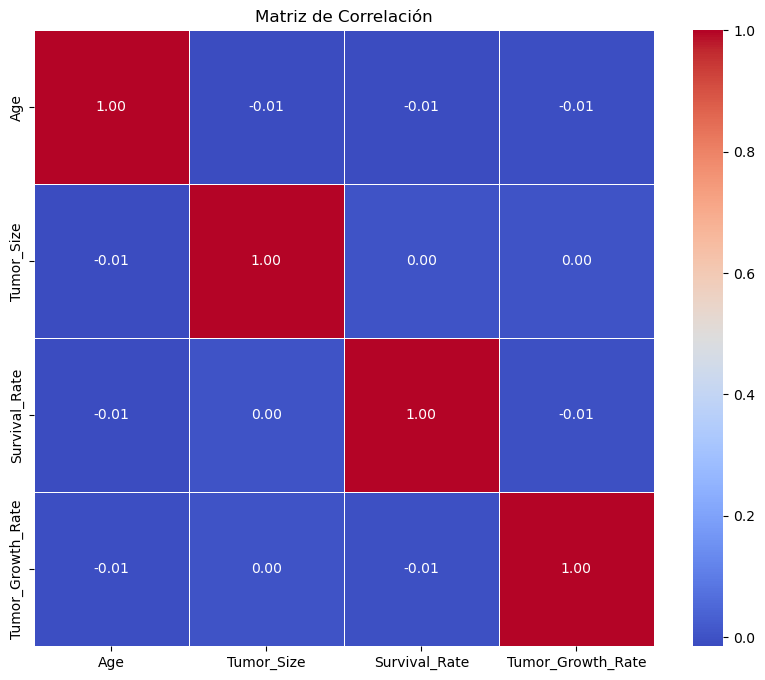

In [169]:
def PlotHeatMap():
    numeric_cols = brainDataset.select_dtypes(include=['float64', 'int64']).columns.tolist()
    correlation_matrix = brainDataset[numeric_cols].corr()
    # Crear un heatmap (mapa de calor) para visualizar la matriz de correlación
    plt.figure(figsize=(10, 8))  # Ajustar el tamaño de la figura
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Matriz de Correlación')
    plt.show()
PlotHeatMap()

Creamos nuevas variables

In [172]:
brainDataset['Tumor_Severity'] = brainDataset['Tumor_Size'] * brainDataset['Tumor_Growth_Rate']

brainDataset['All_Treatments_Administered'] = (brainDataset['Radiation_Treatment'] == 'Yes') & (brainDataset['Surgery_Performed'] == 'Yes') & (brainDataset['Chemotherapy'] == 'Yes')

brainDataset['Critical_Location'] = brainDataset['Location'].apply(lambda x: 1 if x in ['Frontal', 'Temporal'] else 0)

brainDataset['Survival_Classification'] = pd.cut(brainDataset['Survival_Rate'], bins=[0, 30, 70, 100], labels=['Low', 'Medium', 'High'])

brainDataset['Family_History_Age'] = brainDataset['Age'] * brainDataset['Family_History'].map({'Yes': 1, 'No': 0})

brainDataset['Tumor_Treatment_Interaction'] = brainDataset['Tumor_Type'] + '_' + brainDataset['Radiation_Treatment'] + '_' + brainDataset['Surgery_Performed'] + '_' + brainDataset['Chemotherapy']

brainDataset['Tumor_Stage_Severity'] = brainDataset['Tumor_Size'] * brainDataset['Stage'].map({'I': 1, 'II': 2, 'III': 3, 'IV': 4})
brainDataset['Symptom_Treatment_Interaction'] = brainDataset['Symptom_1'] + '_' + brainDataset['Radiation_Treatment'] + '_' + brainDataset['Surgery_Performed']
brainDataset.head()

,Age,Gender,Tumor_Type,Tumor_Size,Location,Histology,Stage,Symptom_1,Symptom_2,Symptom_3,...,MRI_Result,Follow_Up_Required,Tumor_Severity,All_Treatments_Administered,Critical_Location,Survival_Classification,Family_History_Age,Tumor_Treatment_Interaction,Tumor_Stage_Severity,Symptom_Treatment_Interaction
0,73,Male,Malignant,5.375612,Temporal,Astrocytoma,III,Vision Issues,Seizures,Seizures,...,Positive,Yes,0.601400,False,1,Medium,0,Malignant_No_No_No,16.126835,Vision Issues_No_No
1,26,Male,Benign,4.847098,Parietal,Glioblastoma,II,Headache,Headache,Nausea,...,Positive,Yes,10.497532,True,0,Medium,26,Benign_Yes_Yes_Yes,9.694196,Headache_Yes_Yes
2,31,Male,Benign,5.588391,Parietal,Meningioma,I,Vision Issues,Headache,Seizures,...,Negative,No,10.529801,False,0,Medium,0,Benign_No_No_No,5.588391,Vision Issues_No_No
3,29,Male,Malignant,1.436600,Temporal,Medulloblastoma,IV,Vision Issues,Seizures,Headache,...,Negative,No,1.843649,False,1,Medium,29,Malignant_Yes_No_Yes,5.746400,Vision Issues_Yes_No
4,54,Female,Benign,2.417506,Parietal,Glioblastoma,I,Headache,Headache,Seizures,...,Positive,Yes,5.002974,False,0,Medium,0,Benign_No_No_Yes,2.417506,Headache_No_No


Ahora volvemos a verificar las correlaciones del dataset

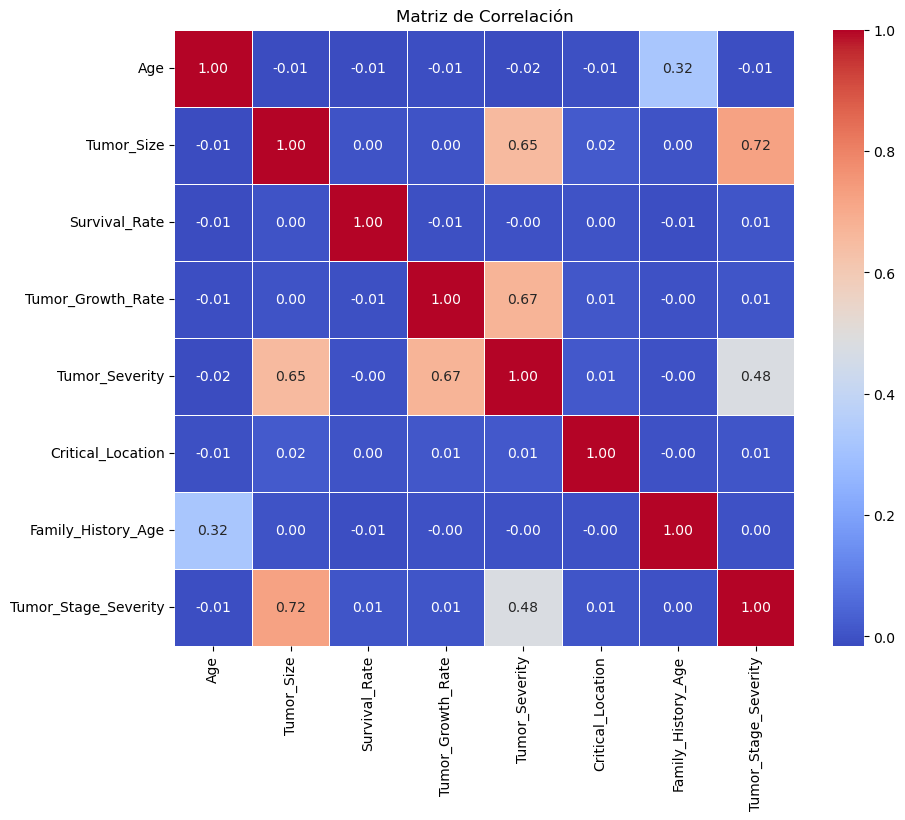

In [175]:
PlotHeatMap()

Separar los datos para validacion y entrenamiento

In [194]:
y=brainDataset['Tumor_Type']
X= brainDataset.drop('Tumor_Type',axis=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

Crear el pipeline para el entrenamiento del modelo de clasificacion y el encoding de las variables categoricas

In [184]:
#Para obtener los nombres de las columnas con datos categoricos y  numericos
s = (X.dtypes == 'object') | (X.dtypes == 'category')
object_cols1 = list(s[s].index)
numeric_cols = brainDataset.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [186]:
# Crear un transformador para las variables categóricas y numericas
preprocessor = ColumnTransformer(
    transformers=[('cat',OneHotEncoder(handle_unknown='ignore'), object_cols1), ('num', StandardScaler(), numeric_cols),   ],
    remainder='passthrough'  # Deja las columnas numéricas sin cambios
)

In [188]:
pipe = make_pipeline( preprocessor  ,RandomForestClassifier(n_estimators=100))

In [190]:
scores =  cross_val_score(pipe, X, y, cv=5 , scoring='accuracy')
print(f"Porcentaje de efectividad {scores.mean() * 100:.2f}%")

Porcentaje de efectividad 100.00%
